In [1]:
import gc
import os
import time
import numpy as np
import pandas as pd


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import defaultdict


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('Data Analyst Test Task Data - Tasks 1-2.csv')


In [9]:
df.head()

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id
0,0001feb9-ec8e-4f53-83c8-a829bbbe1838,2023-05-18 22:16:16,trial,weekly.2.49,False,7,0,0.00,e99b4003-7bb9-4cbe-a585-e8a103b0e3cb,NaN
1,0001feb9-ec8e-4f53-83c8-a829bbbe1838,2023-05-18 22:25:56,cancellation,weekly.2.49,False,7,0,0.00,dc4e828a-f365-46e4-90ef-bb2785379d1a,NaN
2,00026e14-e302-4772-b691-8b0e67ab0c32,2023-05-30 7:10:37,trial,weekly.2.49,False,7,0,0.00,b585adc7-f22a-4cd4-b863-2eb256d697b4,NaN
3,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,purchase,weekly.2.49,False,7,0,2.49,b672df8a-fcb2-4737-8a5f-98a85b183609,NaN
4,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-12 23:10:57,purchase,weekly.2.49,False,7,0,2.49,33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36005 entries, 0 to 36004
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uuid                     36005 non-null  object 
 1   event_timestamp          36005 non-null  object 
 2   event_name               36005 non-null  object 
 3   product_id               36005 non-null  object 
 4   is_trial                 36005 non-null  bool   
 5   period                   36005 non-null  int64  
 6   trial_period             36005 non-null  int64  
 7   revenue_usd              36005 non-null  float64
 8   transaction_id           36005 non-null  object 
 9   refunded_transaction_id  202 non-null    object 
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 2.5+ MB


In [7]:
df.describe()

,event_timestamp,period,trial_period,revenue_usd
count,36005,36005.000000,36005.000000,36005.000000
mean,2023-05-19 11:10:39.822635776,13.152923,1.503541,2.171181
min,2023-03-01 00:05:29,7.000000,0.000000,-9.990000
25%,2023-04-09 21:09:08,7.000000,0.000000,0.000000
50%,2023-05-11 12:58:05,7.000000,3.000000,0.000000
75%,2023-06-12 12:01:40,30.000000,3.000000,4.990000
max,2023-11-15 17:21:04,30.000000,3.000000,9.990000
std,NaN,10.181436,1.500017,3.140630


In [26]:
distinct_dates = df['event_timestamp'].unique()
distinct_dates

array(['2023-05-18 22:16:16', '2023-05-18 22:25:56', '2023-05-30 7:10:37',
       ..., '2023-03-04 16:41:31', '2023-05-09 0:25:58',
       '2023-05-09 0:27:46'], dtype=object)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], format='%Y-%m-%d %H:%M:%S')

#filter only purchase events 
df_purchase = df[df['event_name'] == 'purchase'].copy()

#get first purchase month
df_purchase['event_month'] = df_purchase['event_timestamp'].dt.to_period('M')
first_purchase = df_purchase.groupby('uuid')['event_month'].min().reset_index()
first_purchase.columns = ['uuid', 'first_purchase_month']
first_purchase

,uuid,first_purchase_month
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06
1,0015b6c7-85fb-4c36-9dfb-4ff348c39906,2023-05
2,002d7b10-b35f-4cb4-a345-297f53eaf85e,2023-03
3,002efdd9-47cd-4454-85d5-47d1ad1202b2,2023-03
4,0047993c-3cff-4ab4-a34a-e376f823c282,2023-03
...,...,...
2376,ff4f6ada-2f5d-4273-a5ec-0f4d8c40ad02,2023-05
2377,ff963f4e-b13e-4a4a-a805-201f56cd4d11,2023-05
2378,ff9a70ec-9962-4378-9fab-011780499257,2023-03
2379,ff9c10a1-7510-43e4-873c-9365beffec86,2023-04


In [8]:
#merge the first purchase month with rest of data
df_purchase = df_purchase.merge(first_purchase, on='uuid', how='left')
df_purchase

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id,event_month,first_purchase_month
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,purchase,weekly.2.49,False,7,0,2.49,b672df8a-fcb2-4737-8a5f-98a85b183609,NaN,2023-06,2023-06
1,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-12 23:10:57,purchase,weekly.2.49,False,7,0,2.49,33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN,2023-06,2023-06
2,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-20 23:10:53,purchase,weekly.2.49,False,7,0,2.49,b0e50445-f8bb-4677-86c9-e34f49a274ab,NaN,2023-06,2023-06
3,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-27 23:10:46,purchase,weekly.2.49,False,7,0,2.49,4e9a3204-f64c-4e7f-b2ec-ebbbb813b142,NaN,2023-06,2023-06
4,00026e14-e302-4772-b691-8b0e67ab0c32,2023-07-04 23:10:37,purchase,weekly.2.49,False,7,0,2.49,be75126f-e581-49fc-a84c-8ed682c8d4ca,NaN,2023-07,2023-06
...,...,...,...,...,...,...,...,...,...,...,...,...
15749,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-02 15:20:16,purchase,weekly.2.49,False,7,0,2.49,3112b581-d57e-4eb8-ba03-f46d9b2c7ecf,NaN,2023-09,2023-03
15750,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-08 15:20:21,purchase,weekly.2.49,False,7,0,2.49,328c1907-c025-4525-9b58-c69f71bd80b4,NaN,2023-09,2023-03
15751,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-15 15:20:23,purchase,weekly.2.49,False,7,0,2.49,1dc95ec4-4719-4258-949a-4c64dfbd9773,NaN,2023-09,2023-03
15752,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-23 15:20:07,purchase,weekly.2.49,False,7,0,2.49,f93422d3-e8fa-4eab-a9b0-ecccc63769b4,NaN,2023-09,2023-03


In [9]:

df_filtered = df_purchase[df_purchase['first_purchase_month'].notna()]

df_filtered

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id,event_month,first_purchase_month
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,purchase,weekly.2.49,False,7,0,2.49,b672df8a-fcb2-4737-8a5f-98a85b183609,NaN,2023-06,2023-06
1,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-12 23:10:57,purchase,weekly.2.49,False,7,0,2.49,33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN,2023-06,2023-06
2,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-20 23:10:53,purchase,weekly.2.49,False,7,0,2.49,b0e50445-f8bb-4677-86c9-e34f49a274ab,NaN,2023-06,2023-06
3,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-27 23:10:46,purchase,weekly.2.49,False,7,0,2.49,4e9a3204-f64c-4e7f-b2ec-ebbbb813b142,NaN,2023-06,2023-06
4,00026e14-e302-4772-b691-8b0e67ab0c32,2023-07-04 23:10:37,purchase,weekly.2.49,False,7,0,2.49,be75126f-e581-49fc-a84c-8ed682c8d4ca,NaN,2023-07,2023-06
...,...,...,...,...,...,...,...,...,...,...,...,...
15749,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-02 15:20:16,purchase,weekly.2.49,False,7,0,2.49,3112b581-d57e-4eb8-ba03-f46d9b2c7ecf,NaN,2023-09,2023-03
15750,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-08 15:20:21,purchase,weekly.2.49,False,7,0,2.49,328c1907-c025-4525-9b58-c69f71bd80b4,NaN,2023-09,2023-03
15751,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-15 15:20:23,purchase,weekly.2.49,False,7,0,2.49,1dc95ec4-4719-4258-949a-4c64dfbd9773,NaN,2023-09,2023-03
15752,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-23 15:20:07,purchase,weekly.2.49,False,7,0,2.49,f93422d3-e8fa-4eab-a9b0-ecccc63769b4,NaN,2023-09,2023-03


In [10]:
#get the event month from date
df_filtered['event_month'] = df_filtered['event_timestamp'].dt.to_period('M')

#calculate the cohort lifetime
df_filtered['cohort_lifetime'] = (df_filtered['event_month'].dt.to_timestamp() - df_filtered['first_purchase_month'].dt.to_timestamp()).dt.days // 30
df_filtered

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id,event_month,first_purchase_month,cohort_lifetime
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,purchase,weekly.2.49,False,7,0,2.49,b672df8a-fcb2-4737-8a5f-98a85b183609,NaN,2023-06,2023-06,0
1,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-12 23:10:57,purchase,weekly.2.49,False,7,0,2.49,33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN,2023-06,2023-06,0
2,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-20 23:10:53,purchase,weekly.2.49,False,7,0,2.49,b0e50445-f8bb-4677-86c9-e34f49a274ab,NaN,2023-06,2023-06,0
3,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-27 23:10:46,purchase,weekly.2.49,False,7,0,2.49,4e9a3204-f64c-4e7f-b2ec-ebbbb813b142,NaN,2023-06,2023-06,0
4,00026e14-e302-4772-b691-8b0e67ab0c32,2023-07-04 23:10:37,purchase,weekly.2.49,False,7,0,2.49,be75126f-e581-49fc-a84c-8ed682c8d4ca,NaN,2023-07,2023-06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15749,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-02 15:20:16,purchase,weekly.2.49,False,7,0,2.49,3112b581-d57e-4eb8-ba03-f46d9b2c7ecf,NaN,2023-09,2023-03,6
15750,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-08 15:20:21,purchase,weekly.2.49,False,7,0,2.49,328c1907-c025-4525-9b58-c69f71bd80b4,NaN,2023-09,2023-03,6
15751,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-15 15:20:23,purchase,weekly.2.49,False,7,0,2.49,1dc95ec4-4719-4258-949a-4c64dfbd9773,NaN,2023-09,2023-03,6
15752,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-23 15:20:07,purchase,weekly.2.49,False,7,0,2.49,f93422d3-e8fa-4eab-a9b0-ecccc63769b4,NaN,2023-09,2023-03,6


In [11]:
#create a pivot table to count unique users per cohort and cohort lifetime
cohorts = df_filtered.pivot_table(index=['first_purchase_month', 'cohort_lifetime'],
                          aggfunc={'uuid': 'nunique'}).reset_index()
cohorts

,first_purchase_month,cohort_lifetime,uuid
0,2023-03,0,748
1,2023-03,1,393
2,2023-03,2,251
3,2023-03,3,189
4,2023-03,4,151
5,2023-03,5,113
6,2023-03,6,91
7,2023-03,7,68
8,2023-03,8,18
9,2023-04,0,527


In [12]:
# get the initial number of users in each cohort
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0]
initial_users_count = initial_users_count[['first_purchase_month', 'uuid']]
initial_users_count = initial_users_count.rename(columns={'uuid': 'cohort_users'})

In [13]:
#merge initial_users_count with the cohorts dataframe to get the number of initial customers in each cohort
cohorts = cohorts.merge(initial_users_count, on='first_purchase_month', how='left')
#find the percent of users that remained in each period of time from the initial number of customers in the cohort.
cohorts['retention'] = cohorts['uuid'] / cohorts['cohort_users']

#Retention Rate for each cohort during its lifetime
retention_pivot = cohorts.pivot_table(index='first_purchase_month',
                                       columns='cohort_lifetime',
                                       values='retention',
                                       aggfunc='sum')
retention_pivot


cohort_lifetime,0,1,2,3,4,5,6,7,8
first_purchase_month,,,,,,,,,
2023-03,1.0,0.525401,0.335561,0.252674,0.201872,0.151070,0.121658,0.090909,0.024064
2023-04,1.0,0.565465,0.379507,0.250474,0.203036,0.151803,0.113852,0.034156,NaN
2023-05,1.0,0.512195,0.314363,0.220867,0.161247,0.119241,0.017615,NaN,NaN
2023-06,1.0,0.465587,0.307692,0.194332,0.141700,0.032389,NaN,NaN,NaN
2023-07,1.0,0.510204,0.265306,0.163265,0.040816,NaN,NaN,NaN,NaN
2023-08,1.0,0.525000,0.250000,0.025000,NaN,NaN,NaN,NaN,NaN
2023-09,1.0,0.363636,0.090909,NaN,NaN,NaN,NaN,NaN,NaN
2023-10,1.0,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


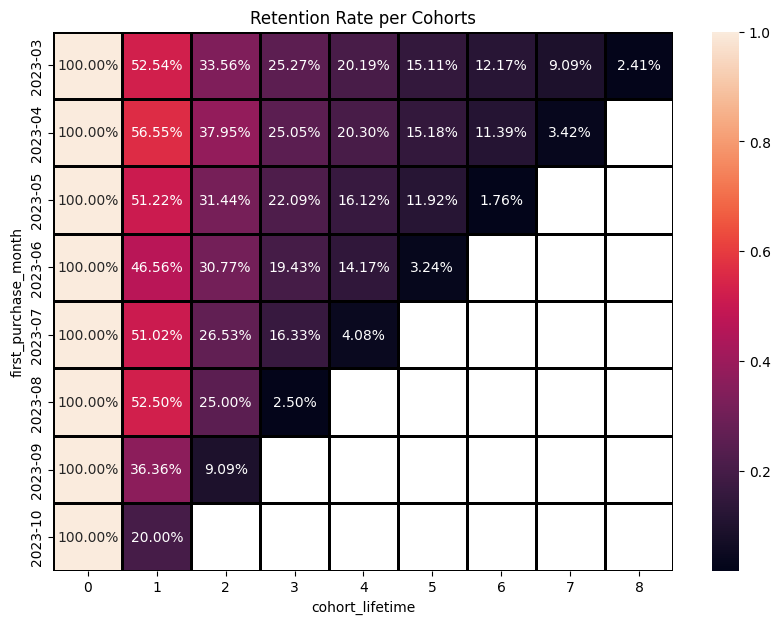

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
plt.title('Retention Rate per Cohorts')
sns.heatmap(retention_pivot.iloc[:, 0:], annot=True, 
            fmt='.2%', linewidths=1, linecolor='black'); 

In [15]:
#counting ltv per customer 
# customer value x average customer lifespan
# customer value = total_revenue / total_purchases

customer_value = df_filtered.groupby('uuid').agg(
    total_revenue=('revenue_usd', 'sum'),
    total_purchases=('uuid', 'count') 
).reset_index()

customer_value['customer_value'] = customer_value['total_revenue'] / customer_value['total_purchases']


In [16]:
df_filtered['purchase_date'] = pd.to_datetime(df_filtered['event_timestamp'])

customer_lifespan = df_filtered.groupby('uuid').agg(
    first_purchase=('purchase_date', 'min'),
    last_purchase=('purchase_date', 'max')
).reset_index()

# calculate customer lifespan
customer_lifespan['lifespan_days'] = (customer_lifespan['last_purchase'] - customer_lifespan['first_purchase']).dt.days
customer_lifespan['lifespan_months'] = customer_lifespan['lifespan_days'] / 30 
customer_lifespan

,uuid,first_purchase,last_purchase,lifespan_days,lifespan_months
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,2023-10-16 23:10:38,132,4.400000
1,0015b6c7-85fb-4c36-9dfb-4ff348c39906,2023-05-20 16:09:05,2023-06-22 00:27:13,32,1.066667
2,002d7b10-b35f-4cb4-a345-297f53eaf85e,2023-03-18 16:17:02,2023-03-18 16:17:02,0,0.000000
3,002efdd9-47cd-4454-85d5-47d1ad1202b2,2023-03-28 13:21:19,2023-05-04 13:22:13,37,1.233333
4,0047993c-3cff-4ab4-a34a-e376f823c282,2023-03-22 06:02:55,2023-03-22 06:02:55,0,0.000000
...,...,...,...,...,...
2376,ff4f6ada-2f5d-4273-a5ec-0f4d8c40ad02,2023-05-30 15:13:04,2023-05-30 15:13:04,0,0.000000
2377,ff963f4e-b13e-4a4a-a805-201f56cd4d11,2023-05-03 16:02:22,2023-05-23 16:02:19,19,0.633333
2378,ff9a70ec-9962-4378-9fab-011780499257,2023-03-05 21:37:13,2023-10-22 15:32:44,230,7.666667
2379,ff9c10a1-7510-43e4-873c-9365beffec86,2023-04-23 15:02:39,2023-10-07 15:03:25,167,5.566667


In [17]:
# merge customer lifespan with first purchase to get cohort information
customer_lifespan = customer_lifespan.merge(first_purchase, on='uuid', how='left')

customer_lifespan

,uuid,first_purchase,last_purchase,lifespan_days,lifespan_months,first_purchase_month
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,2023-10-16 23:10:38,132,4.400000,2023-06
1,0015b6c7-85fb-4c36-9dfb-4ff348c39906,2023-05-20 16:09:05,2023-06-22 00:27:13,32,1.066667,2023-05
2,002d7b10-b35f-4cb4-a345-297f53eaf85e,2023-03-18 16:17:02,2023-03-18 16:17:02,0,0.000000,2023-03
3,002efdd9-47cd-4454-85d5-47d1ad1202b2,2023-03-28 13:21:19,2023-05-04 13:22:13,37,1.233333,2023-03
4,0047993c-3cff-4ab4-a34a-e376f823c282,2023-03-22 06:02:55,2023-03-22 06:02:55,0,0.000000,2023-03
...,...,...,...,...,...,...
2376,ff4f6ada-2f5d-4273-a5ec-0f4d8c40ad02,2023-05-30 15:13:04,2023-05-30 15:13:04,0,0.000000,2023-05
2377,ff963f4e-b13e-4a4a-a805-201f56cd4d11,2023-05-03 16:02:22,2023-05-23 16:02:19,19,0.633333,2023-05
2378,ff9a70ec-9962-4378-9fab-011780499257,2023-03-05 21:37:13,2023-10-22 15:32:44,230,7.666667,2023-03
2379,ff9c10a1-7510-43e4-873c-9365beffec86,2023-04-23 15:02:39,2023-10-07 15:03:25,167,5.566667,2023-04


In [18]:
#get avarage lifespan
avg_lifespan_per_cohort = customer_lifespan.groupby('first_purchase_month').agg(
    avg_lifespan=('lifespan_months', 'mean')  
).reset_index()
avg_lifespan_per_cohort

,first_purchase_month,avg_lifespan
0,2023-03,1.771791
1,2023-04,1.717141
2,2023-05,1.419467
3,2023-06,1.292173
4,2023-07,1.018367
5,2023-08,0.730000
6,2023-09,0.410606
7,2023-10,0.223333


In [19]:
# merge customer value and average lifespan
ltv_data = customer_value.merge(first_purchase, on='uuid', how='left')

ltv_data = ltv_data.merge(avg_lifespan_per_cohort, on='first_purchase_month', how='left')

# calculate LTV
ltv_data['ltv_per_customer'] = ltv_data['customer_value'] * ltv_data['avg_lifespan']
ltv_data

,uuid,total_revenue,total_purchases,customer_value,first_purchase_month,avg_lifespan,ltv_per_customer
0,00026e14-e302-4772-b691-8b0e67ab0c32,49.80000,20,2.49000,2023-06,1.292173,3.217510
1,0015b6c7-85fb-4c36-9dfb-4ff348c39906,26.41728,6,4.40288,2023-05,1.419467,6.249743
2,002d7b10-b35f-4cb4-a345-297f53eaf85e,4.99000,1,4.99000,2023-03,1.771791,8.841239
3,002efdd9-47cd-4454-85d5-47d1ad1202b2,29.97000,3,9.99000,2023-03,1.771791,17.700197
4,0047993c-3cff-4ab4-a34a-e376f823c282,2.49000,1,2.49000,2023-03,1.771791,4.411761
...,...,...,...,...,...,...,...
2376,ff4f6ada-2f5d-4273-a5ec-0f4d8c40ad02,6.43690,1,6.43690,2023-05,1.419467,9.136967
2377,ff963f4e-b13e-4a4a-a805-201f56cd4d11,19.96000,4,4.99000,2023-05,1.419467,7.083140
2378,ff9a70ec-9962-4378-9fab-011780499257,39.84000,16,2.49000,2023-03,1.771791,4.411761
2379,ff9c10a1-7510-43e4-873c-9365beffec86,124.75000,25,4.99000,2023-04,1.717141,8.568534


In [ ]:
ltv_data['first_purchase_month'] = pd.to_datetime(ltv_data['first_purchase_month'])

In [24]:
X = ltv_data[['customer_value', 'avg_lifespan']]
# target variable (e.g., the LTV)
y = ltv_data['ltv_per_customer']


In [25]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
ltv_data['purchase_month'] = ltv_data['first_purchase_month'].dt.month
X = ltv_data[['avg_lifespan', 'total_revenue', 'total_purchases', 'purchase_month']]
y = ltv_data['ltv_per_customer']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [40]:
#make predictions
y_pred = model.predict(X_test)

# Create a DataFrame to compare actual vs predicted values
results = pd.DataFrame({
    'Actual LTV': y_test,
    'Predicted LTV': y_pred
}).reset_index(drop=True)

print(results)


     Actual LTV  Predicted LTV
0     16.909259      22.361848
1     14.180476      11.285293
2      7.083140       7.204366
3      8.841239       8.883345
4      7.083140       7.205575
..          ...            ...
472    4.411761       5.082327
473   13.270718       9.137874
474    8.841239       8.889388
475   17.154239       9.583436
476    7.083140       7.205575

[477 rows x 2 columns]


In [44]:
#evaluate performance
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')


Mean Squared Error: 10.198767573331956


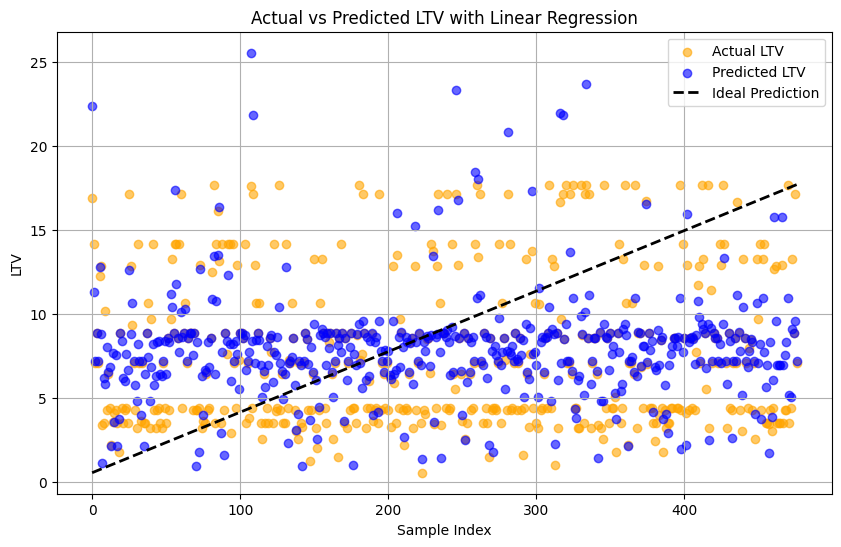

In [43]:
# Plot actual vs predicted LTV with distinct colors
plt.figure(figsize=(10, 6))

# Scatter plot for Actual LTV
plt.scatter(results.index, results['Actual LTV'], color='orange', label='Actual LTV', alpha=0.6)

# Scatter plot for Predicted LTV
plt.scatter(results.index, results['Predicted LTV'], color='blue', label='Predicted LTV', alpha=0.6)

# Adding the ideal prediction line (for comparison)
plt.plot([results.index.min(), results.index.max()], 
         [results['Actual LTV'].min(), results['Actual LTV'].max()], 
         'k--', lw=2, label='Ideal Prediction')  # Diagonal line for ideal predictions

# Adding titles and labels
plt.xlabel('Sample Index')
plt.ylabel('LTV')
plt.title('Actual vs Predicted LTV with Linear Regression')
plt.legend()  # Add a legend to the plot
plt.grid()
plt.show()
